In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchviz import make_dot
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import tqdm
import cma

%matplotlib inline

In [10]:
print(torch.cuda.is_available())

True


In [11]:
print(torch.cuda.device_count())

1


## VAE

In [4]:
class Encoder(nn.Module):
    """Encoder"""

    def __init__(self, z_dim=32):
        super().__init__()
        self.z_dim = z_dim

        self.conv1 = nn.Conv2d(3, 32, 4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2) 
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2)

        self.mu = nn.Linear(256*2*2, z_dim)
        self.logvar = nn.Linear(256*2*2, z_dim)

        self.relu = nn.ReLU()

    def forward(self, x):
        # x: [batch_size, 3, 64, 64]
        c1 = self.conv1(x) # (64x64x3) -> (31x31x32)
        h1 = self.relu(c1) # (31x31x32) -> (31x31x32)
        c2 = self.conv2(h1) # (31x31x32) -> (14x14x64)
        h2 = self.relu(c2) # (14x14x64) -> (14x14x64)
        c3 = self.conv3(h2) # (14x14x64) -> (6x6x128)
        h3 = self.relu(c3) # (6x6x128) -> (6x6x128)
        c4 = self.conv4(h3) # (6x6x128) -> (2x2x256)
        h4 = self.relu(c4) # (2x2x256) -> (2x2x256)

        d1 = h4.view(-1, 256*2*2) # (2x2x256) -> (1024)

        mu = self.mu(d1) # (1024) -> (32)
        logvar = self.logvar(d1) # (1024) -> (32)
        var = torch.exp(logvar)
        std = torch.sqrt(var)

        ep = torch.randn_like(std)

        z = mu + ep * std # (32) -> (32)

        return z, mu, logvar

In [5]:
class Decoder(nn.Module):
    """Decoder"""
    def __init__(self, z_dim=32):
        super().__init__()
        self.z_dim = z_dim

        self.l1 = nn.Linear(z_dim, 1024*1*1)

        self.deconv1 = nn.ConvTranspose2d(1024, 128, 5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 6, stride=2)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z):
        # z: [batch_size, 32]
        d1 = self.l1(z) # (32) -> (1024)
        d1 = d1.view(-1, 1024, 1, 1) # (1024) -> (1x1x1024)

        dc1 = self.deconv1(d1) # (1x1x1024) -> (5x5x128)
        h1 = self.relu(dc1) # (5x5x128) -> (5x5x128)
        dc2 = self.deconv2(h1) # (5x5x128) -> (13x13x64)
        h2 = self.relu(dc2) # (13x13x64) -> (13x13x64)
        dc3 = self.deconv3(h2) # (13x13x64) -> (30x30x32)
        h3 = self.relu(dc3) # (30x30x32) -> (30x30x32)
        dc4 = self.deconv4(h3) # (30x30x32) -> (64x64x3)
        x = self.sigmoid(dc4) # (64x64x3) -> (64x64x3)

        return x

In [6]:
class VAE(nn.Module):
    '''VAE'''
    def __init__(self, z_dim=32):
        super().__init__()
        self.z_dim = z_dim

        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)

    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        x = self.decoder(z)

        return x, mu, logvar

In [7]:
encoder = Encoder()

In [8]:
summary(encoder, (3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 32]                   --
├─Conv2d: 1-1                            [32, 31, 31]              1,568
├─ReLU: 1-2                              [32, 31, 31]              --
├─Conv2d: 1-3                            [64, 14, 14]              32,832
├─ReLU: 1-4                              [64, 14, 14]              --
├─Conv2d: 1-5                            [128, 6, 6]               131,200
├─ReLU: 1-6                              [128, 6, 6]               --
├─Conv2d: 1-7                            [256, 2, 2]               524,544
├─ReLU: 1-8                              [256, 2, 2]               --
├─Linear: 1-9                            [1, 32]                   32,800
├─Linear: 1-10                           [1, 32]                   32,800
Total params: 755,744
Trainable params: 755,744
Non-trainable params: 0
Total mult-adds (M): 400.37
Input size (MB): 0.05
Forward/

In [9]:
decoder = Decoder()

In [10]:
summary(decoder, (32,))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [1, 3, 64, 64]            --
├─Linear: 1-1                            [1024]                    33,792
├─ConvTranspose2d: 1-2                   [1, 128, 5, 5]            3,276,928
├─ReLU: 1-3                              [1, 128, 5, 5]            --
├─ConvTranspose2d: 1-4                   [1, 64, 13, 13]           204,864
├─ReLU: 1-5                              [1, 64, 13, 13]           --
├─ConvTranspose2d: 1-6                   [1, 32, 30, 30]           73,760
├─ReLU: 1-7                              [1, 32, 30, 30]           --
├─ConvTranspose2d: 1-8                   [1, 3, 64, 64]            3,459
├─Sigmoid: 1-9                           [1, 3, 64, 64]            --
Total params: 3,592,803
Trainable params: 3,592,803
Non-trainable params: 0
Total mult-adds (M): 231.70
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 14.37
Estimated Tota

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE()

In [12]:
summary(vae, (3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 3, 64, 64]            --
├─Encoder: 1-1                           [1, 32]                   --
│    └─Conv2d: 2-1                       [32, 31, 31]              1,568
│    └─ReLU: 2-2                         [32, 31, 31]              --
│    └─Conv2d: 2-3                       [64, 14, 14]              32,832
│    └─ReLU: 2-4                         [64, 14, 14]              --
│    └─Conv2d: 2-5                       [128, 6, 6]               131,200
│    └─ReLU: 2-6                         [128, 6, 6]               --
│    └─Conv2d: 2-7                       [256, 2, 2]               524,544
│    └─ReLU: 2-8                         [256, 2, 2]               --
│    └─Linear: 2-9                       [1, 32]                   32,800
│    └─Linear: 2-10                      [1, 32]                   32,800
├─Decoder: 1-2                           [1, 3, 64, 64]     

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

In [ ]:
transform_data = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = CIFAR10(root='./data3', train=True, download=True, transform=transform_data)
test_dataset = CIFAR10(root='./data3', train=False, download=True, transform=transform_data)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
def criterion(predict, target, ave, log_dev):
  bce_loss = F.binary_cross_entropy(predict, target, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + log_dev - ave**2 - log_dev.exp())
  loss = bce_loss + kl_loss
  return loss

net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
history = {'train_loss': []}

epochs = 10

for epoch in range(epochs):
    for i, (img, _) in enumerate(train_loader):
        img = img.to(device)
        output, mu, logvar = net(img)
        loss = criterion(output, img, mu, logvar)
        history['train_loss'].append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')

epoch: 0, step: 0, loss: 1090621.375
epoch: 0, step: 100, loss: 989722.9375


KeyboardInterrupt: 

In [ ]:
g = make_dot(output, params=dict(net.named_parameters()))
g.view()

'Digraph.gv.pdf'

## MDN-RNN

In [ ]:
# class MDMRNN(nn.Module):
#     """MDN-RNN"""
#     def __init__(self, num_mixtures, hidden_size,  z_size, a_size, r_size, num_layers, batch_size, sequence_len, output_size):
#         super().__init__()
#         self.z_size = z_size # 潜在状態の次元
#         self.a_size = a_size # 行動の次元
#         self.r_size = r_size # 報酬の次元
#         self.input_size = z_size + a_size + r_size # 入力の次元
#         self.num_mixtures = num_mixtures # 正規分布の数
#         self.hidden_size = hidden_size # 隠れ層の次元
#         self.num_layers = num_layers # LSTMの層数
#         self.batch_size = batch_size # バッチサイズ
#         self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers) # LSTM
#         self.sequence_len = sequence_len # シーケンスの長さ
#         self.output_size = output_size # 出力の次元
#         self.dense = nn.Linear(self.hidden_size, self.output_size * num_mixtures * 3) # 全結合層
    
#     def forward(self, x, hidden_state, cell_state):
#         x = x.view(self.sequence_len, self.batch_size, self.input_size)
#         z, hidden_states = self.lstm(x, (hidden_state, cell_state))
#         hidden = hidden_states[0]
#         cell = hidden_states[1]
#         z = z.view(-1, self.hidden_size)
#         z = self.dense(z)
#         z = z.view(-1, self.num_mixtures * 3)
#         out_logmix, out_mean, out_log_std = get_mdn_coef(z, self.num_mixtures)
#         return out_logmix, out_mean, out_log_std, hidden, cell

In [17]:
class LSTM(nn.Module):
    """LSTM"""
    def __init__(self, z_size, a_size, hidden_size=256, num_layers=1):
        super().__init__()
        self.z_size = z_size
        self.a_size = a_size
        self.hidden_size = hidden_size
        self.input_size = z_size + a_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers, batch_first=False) # LSTM：入力サイズ、隠れ層サイズ、層数、バイアス、バッチファースト

    def forward(self, x, hidden_state, cell_state):
        # x: [seq_len, batch_size, z_size + a_size]
        output, hidden_cell = self.lstm(x, (hidden_state, cell_state))
        hidden = hidden_cell[0]
        cell = hidden_cell[1]
        # output: [seq_len, batch_size, hidden_size]
        # hidden: [num_layers, batch_size, hidden_size]
        # cell: [num_layers, batch_size, hidden_size]
        return output, hidden, cell


In [ ]:
class LSTM(nn.Module):
    """LSTM"""
    def __init__(self, z_size, a_size, hidden_size=256, num_layers=1):
        super().__init__()
        self.z_size = z_size
        self.a_size = a_size
        self.hidden_size = hidden_size
        self.input_size = z_size + a_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers, batch_first=False) # LSTM：入力サイズ、隠れ層サイズ、層数、バイアス、バッチファースト
    
    def forward(self, x, hidden_state, cell_state):
        output, hidden_cell = self.lstm(x, (hidden_state, cell_state))
        hidden = hidden_cell[0]
        cell = hidden_cell[1]
        return output, hidden, cell

In [18]:
class MDN(nn.Module):
    """Mixture Density Network"""
    def __init__(self, hidden_size=256, z_size=32, r_size=0, num_gaussians=5):
        super().__init__()
        self.hidden_size = hidden_size
        self.z_size = z_size
        self.num_gaussians = num_gaussians
        self.output_size = num_gaussians * 3 *  z_size + r_size # 3: mu, log_sigma, pi, r_size: reward

        self.fc = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, x):
        # x: [seq_len, batch_size, hidden_size]
        output = self.fc(x)
        # output: [seq_len, batch_size, num_gaussians * 3 * z_size + r_size]
        p, mu, logsigma, r = self.split_mdn_params(output)
        return p, mu, logsigma, r
    
    def split_mdn_params(self, output):
        # output: [seq_len, batch_size, num_gaussians * 3 * z_size + r_size]
        p = output[:, :, :self.num_gaussians]
        mu = output[:, :, self.num_gaussians:self.num_gaussians * (self.z_size + 1)]
        logsigma = output[:, :, self.num_gaussians * (self.z_size + 1):self.num_gaussians * (self.z_size * 2 + 1)]
        r = output[:, :, -1]

        # p: [seq_len, batch_size, num_gaussians]
        # mu: [seq_len, batch_size, num_gaussians * z_size]
        # sigma: [seq_len, batch_size, num_gaussians * z_size]
        # r: [seq_len, batch_size, r_size]

        p = F.softmax(p, dim=2)
        sigma = torch.exp(sigma)
        return p, mu, sigma, r

In [19]:
class MDRNN(nn.Module):
    """MDN-RNN"""
    def __init__(self, z_size, a_size, r_size, hidden_size=256, num_layers=1, num_gaussians=5):
        super().__init__()
        self.z_size = z_size
        self.a_size = a_size
        self.r_size = r_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_gaussians = num_gaussians

        self.lstm = LayerNormBasicLSTM(z_size, a_size, hidden_size, num_layers)
        self.mdn = MDN(hidden_size, z_size, r_size, num_gaussians)

    def forward(self, z, a):
        # z: [seq_len, batch_size, z_size]
        # a: [seq_len, batch_size, a_size]
        za = torch.cat([z, a], dim=2)
        # za: [seq_len, batch_size, z_size + a_size]
        output, (h_n, c_n) = self.lstm(za)
        # output: [seq_len, batch_size, hidden_size]
        # h_n: [num_layers, batch_size, hidden_size]
        # c_n: [num_layers, batch_size, hidden_size]
        p, mu, sigma, r = self.mdn(output)
        # p: [seq_len, batch_size, num_gaussians]
        # mu: [seq_len, batch_size, num_gaussians * z_size]
        # sigma: [seq_len, batch_size, num_gaussians * z_size]
        # r: [seq_len, batch_size, r_size]
        return output, p, mu, sigma, r


In [20]:
lstm = LayerNormBasicLSTM(32, 3)

In [21]:
summary(lstm, (1, 1, 35))

Layer (type:depth-idx)                   Output Shape              Param #
LayerNormBasicLSTM                       [1, 1, 256]               --
├─LSTM: 1-1                              [1, 1, 256]               300,032
Total params: 300,032
Trainable params: 300,032
Non-trainable params: 0
Total mult-adds (M): 0.30
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.20
Estimated Total Size (MB): 1.20

In [22]:
mdn = MDN(256, 32, 0)

In [23]:
summary(mdn, (1, 1, 256))

Layer (type:depth-idx)                   Output Shape              Param #
MDN                                      [1, 1, 5]                 --
├─Linear: 1-1                            [1, 1, 480]               123,360
Total params: 123,360
Trainable params: 123,360
Non-trainable params: 0
Total mult-adds (M): 0.12
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.49
Estimated Total Size (MB): 0.50

In [24]:
mdnrnn = MDRNN(32, 3, 0)

In [25]:
summary(mdnrnn, [(1, 1, 32), (1, 1, 3)])

Layer (type:depth-idx)                   Output Shape              Param #
MDRNN                                    [1, 1, 256]               --
├─LayerNormBasicLSTM: 1-1                [1, 1, 256]               --
│    └─LSTM: 2-1                         [1, 1, 256]               300,032
├─MDN: 1-2                               [1, 1, 5]                 --
│    └─Linear: 2-2                       [1, 1, 480]               123,360
Total params: 423,392
Trainable params: 423,392
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.69
Estimated Total Size (MB): 1.70

In [6]:
class Controller(nn.Module):
    """Controller"""

    def __init__(self, a_size, h_size=256, z_size=32):
        super().__init__()
        self.a_size = a_size
        self.h_size = h_size
        self.z_size = z_size
        self.input_size = z_size + h_size
        self.fc = nn.Linear(self.input_size, a_size)

    def forward(self, z, h):
        # z: [batch_size, z_size]
        # h: [batch_size, h_size]
        zh = torch.cat([z, h], dim=1)
        # zh: [batch_size, z_size + h_size]
        a = self.fc(zh)
        # a: [batch_size, a_size]
        return a

In [7]:
c = Controller(3)

summary(c, [(1, 32), (1, 256)])

Layer (type:depth-idx)                   Output Shape              Param #
Controller                               [1, 3]                    --
├─Linear: 1-1                            [1, 3]                    867
Total params: 867
Trainable params: 867
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Env

In [2]:
import gym
from gym.spaces.box import Box
from gym.envs.box2d.car_racing import CarRacing
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr

In [11]:
env = gym.make('CarRacing-v2')
state, _ = env.reset()

In [15]:
SCREEN_X = 64 # 画像の横幅
SCREEN_Y = 64 # 画像の縦幅

In [16]:
#ゲームの選択
env = gym.make('CarRacing-v2', render_mode='rgb_array')

#デフォルトのactionsの確認（steer, gas, brakeの3次元連続値）
print('env.action_space: {}'.format(env.action_space))

#アクションを離散値で用意しておく
actions = np.array([[ 0, 0, 0],  #actions[0]：何もしない（＝等速直線運動）
                    [ 0, 1, 0],  #actions[1]：加速
                    [ 0, 0, 1],  #actions[2]：減速
                    [ 1, 0, 0],  #actions[3]：右旋回
                    [-1, 0, 0]]) #actions[4]：左旋回
print('actions:\n{}'.format(actions))

env.action_space: Box([-1.  0.  0.], 1.0, (3,), float32)
actions:
[[ 0  0  0]
 [ 0  1  0]
 [ 0  0  1]
 [ 1  0  0]
 [-1  0  0]]


In [17]:
import tqdm
import os

env = gym.make('CarRacing-v2', render_mode='rgb_array')

def get_rollouts(num_rollouts=10000, reflesh_rate=20, file_dir='./data/'):
    for i in tqdm.tqdm(range(num_rollouts)):
        state_sequence = []
        action_sequence = []
        reward_sequence = []
        done_sequence = []
        state = env.reset()
        done = False
        iter = 0
        while not done:
            if iter % reflesh_rate == 0:
                if iter < 20:
                    steering = -0.1
                    acceleration = 1
                    brake = 0
                else:
                    steering = nr.uniform(-1, 1)
                    acceleration = nr.uniform(0, 1)
                    brake = nr.uniform(0, 1)
            action = np.array([steering, acceleration, brake])
            state, reward, done, _, _ = env.step(action)
            state = reshape_state(state)
            state_sequence.append(state)
            action_sequence.append(action)
            reward_sequence.append(reward)
            done_sequence.append(done)
            iter += 1
        np.savez_compressed(os.path.join(file_dir, 'rollout_{}.npz'.format(i)), state=state_sequence, action=action_sequence, reward=reward_sequence, done=done_sequence)

def load_rollout(idx_rolloout, file_dir='./data/'):
    data = np.load(os.path.join(file_dir, 'rollout_{}.npz'.format(idx_rolloout)))
    return data['state'], data['action'], data['reward'], data['done']

def reshape_state(state):
    HEIGHT = 64
    WIDTH = 64
    state = state[0:84, :, :]
    state = np.array(Image.fromarray(state).resize((HEIGHT, WIDTH)))
    state = state / 255.0
    return state
    


In [18]:
state[0].shape

(96, 3)

In [19]:
reshape_state(state[0]).shape

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

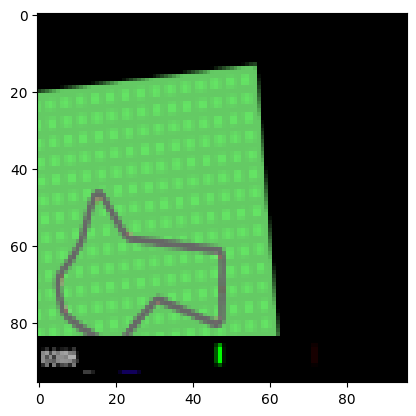

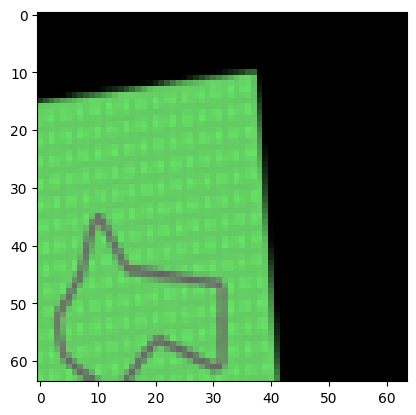

In [123]:
import matplotlib.pyplot as plt

plt.imshow(state[0])
plt.show()

plt.imshow(reshape_state(state[0]))
plt.show()

In [ ]:
state, _ = env.reset()

#初期画像を表示
plt.figure()
plt.imshow(env.render())
plt.show()

#ランダムにアクション（1アクションは4フレーム継続）
for i in range(10):
    for _ in range(4):
        #アクションの選択
        rand = nr.randint(5)

        #状態の更新
        state, reward, done, info, _ = env.step(actions[rand])
        print('reward:{}'.format(reward))
        
    #1アクション（＝4フレーム）毎に画像を表示
    plt.figure()
    plt.imshow(env.render())
    plt.show()

In [36]:
env.reset()

observation, reward, done, info, _ = env.step(env.action_space.sample())

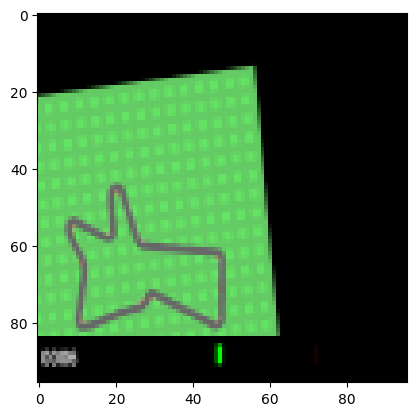

In [37]:
plt.imshow(observation)

In [1]:
import os

os.cpu_count()

8

In [15]:
import tqdm
import os
import gym
from PIL import Image
import numpy as np
import numpy.random as nr
import argparse

class CarRacing_rollouts():
    def __init__(self, max_episode=200):
        self.env = gym.make('CarRacing-v2', render_mode='rgb_array', domain_randomize=True)
        self.env.reset()
        self.file_dir = './data/'
        self.max_episode = 200

    def get_rollout(self, file_number, reflesh_rate=20):
        state_sequence = []
        action_sequence = []
        reward_sequence = []
        done_sequence = []
        state = self.env.reset(seed=file_number)
        done = False
        iter = 0
        while (not done) and (iter < self.max_episode):
            if iter % reflesh_rate == 0:
                if iter < 20:
                    steering = -0.1
                    acceleration = 1
                    brake = 0
                else:
                    steering = nr.uniform(-1, 1)
                    acceleration = nr.uniform(0, 1)
                    brake = nr.uniform(0, 1)
            action = np.array([steering, acceleration, brake])
            state, reward, done, _, _ = self.env.step(action)
            state = self.reshape_state(state)
            state_sequence.append(state)
            action_sequence.append(action)
            reward_sequence.append(reward)
            done_sequence.append(done)
            iter += 1
        np.savez_compressed(os.path.join(self.file_dir, 'rollout_{}.npz'.format(i)), state=state_sequence, action=action_sequence, reward=reward_sequence, done=done_sequence)
        print('rollout_{}.npz is saved.'.format(i))

    def get_rollouts(self, num_rollouts=10000, reflesh_rate=20):
        start_idx = 0
        if os.path.exists(self.file_dir):
            start_idx = len(os.listdir(self.file_dir)) 
        for i in tqdm.tqdm(range(start_idx, num_rollouts+1)):
            state_sequence = []
            action_sequence = []
            reward_sequence = []
            done_sequence = []
            state = self.env.reset()
            done = False
            iter = 0
            while not done:
                if iter % reflesh_rate == 0:
                    if iter < 20:
                        steering = -0.1
                        acceleration = 1
                        brake = 0
                    else:
                        steering = nr.uniform(-1, 1)
                        acceleration = nr.uniform(0, 1)
                        brake = nr.uniform(0, 1)
                action = np.array([steering, acceleration, brake])
                state, reward, done, _, _ = self.env.step(action)
                state = self.reshape_state(state)
                state_sequence.append(state)
                action_sequence.append(action)
                reward_sequence.append(reward)
                done_sequence.append(done)
                iter += 1
            np.savez_compressed(os.path.join(self.file_dir, 'rollout_{}.npz'.format(i)), state=state_sequence, action=action_sequence, reward=reward_sequence, done=done_sequence)

    def load_rollout(self, idx_rolloout):
        data = np.load(os.path.join(self.file_dir, 'rollout_{}.npz'.format(idx_rolloout)))
        return data['state'], data['action'], data['reward'], data['done']

    def reshape_state(self, state):
        HEIGHT = 64
        WIDTH = 64
        state = state[0:84, :, :]
        state = np.array(Image.fromarray(state).resize((HEIGHT, WIDTH)))
        state = state / 255.0
        return state
    
    def make_gif(self, idx_rolloout):
        state, _, _, _ = self.load_rollout(idx_rolloout, self.file_dir)
        state = state * 255.0
        state = state.astype(np.uint8)
        for i in range(len(state)):
            img = Image.fromarray(state[i])
            img.save(os.path.join(self.file_dir, 'rollout_{}.gif'.format(idx_rolloout, i)))

In [35]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import os
import time

# 並列処理の実行：CarRacingのロールアウトデータの取得
Cr = CarRacing_rollouts()
with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
    executor.submit(, num_rollouts=10000, reflesh_rate=20)

In [72]:
import matplotlib.pyplot as plt

env = gym.make('CarRacing-v2', render_mode='rgb_array')
s, _ = env.reset(seed=123)
s, _ = env.reset()

#初期画像を表示
pil_im = Image.fromarray(s[0:84, :, :])
pil_im.show()

In [73]:
def reshape_state(s):
    HEIGHT = 64
    WIDTH = 64
    s = state[0:84, :, :]
    s = np.array(Image.fromarray(s).resize((HEIGHT, WIDTH)))
    s = s / 255.0
    return s

re_state = reshape_state(s)

In [74]:
re_state.shape

(64, 64, 3)

In [75]:
save_npz = np.savez_compressed('./re_sate.npz', state=re_state)

In [76]:
re_state = np.load('./re_sate.npz')['state'] * 255.0

In [77]:
re_state.shape

(64, 64, 3)

In [78]:
pil_im_re = Image.fromarray(re_state.astype("uint8"))
pil_im_re.show()

In [87]:
state_sequence = []
action_sequence = []
reward_sequence = []
done_sequence = []
state = env.reset()
done = False
iter = 0
max_episode = 300
reflesh_rate = 20
while (not done) and iter < max_episode:
    if iter % reflesh_rate == 0:
        if iter < 20:
            steering = -0.1
            acceleration = 1
            brake = 0
        else:
            steering = nr.uniform(-1, 1)
            acceleration = nr.uniform(0, 1)
            brake = nr.uniform(0, 1)
    action = np.array([steering, acceleration, brake])
    state, reward, done, _, _ = env.step(action)
    state = reshape_state(state)
    state_sequence.append(state)
    action_sequence.append(action)
    reward_sequence.append(reward)
    done_sequence.append(done)
    iter += 1
np.savez_compressed('rollout_test.npz', state=state_sequence, action=action_sequence, reward=reward_sequence, done=done_sequence)

In [89]:
test_states = np.load('rollout_test.npz')['state']
re_test_states = test_states[0] * 255.0
re_test_states.shape

(64, 64, 3)

In [90]:
im_re_test_states = Image.fromarray(re_test_states.astype("uint8"))
im_re_test_states.show()

## VAE Train

In [49]:
from models.VAE import VAE

In [50]:
import rollout

rollout = rollout.CarRacing_rollouts()

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets

lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

# 学習
num_batches = 1
num_epochs = 10000

def loss_function(label, predict, mu, log_var, kl_tolerance=0.5, z_size=32):
    r_loss = torch.sum((predict - label).pow(2), dim=(1, 2, 3))
    r_loss = torch.mean(r_loss)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1)
    kl_loss = torch.max(kl_loss, kl_loss.new([kl_tolerance * z_size]))
    kl_loss = torch.mean(kl_loss)
    return r_loss.detach().cpu().numpy(), kl_loss.detach().cpu().numpy(), r_loss + kl_loss

for batch in range(num_batches):
    for epoch in range(num_epochs):
        states, _, _, _ = rollout.load_rollout(epoch)
        inputs = torch.tensor(states).permute(0, 3, 1, 2).float()
        labels = torch.tensor(states).permute(0, 3, 1, 2).float()
        inputs_train = inputs[0:int(len(inputs)*0.7)]
        inputs_test = inputs[int(len(inputs)*0.7):]
        labels_train = labels[0:int(len(inputs)*0.7)]
        labels_test = labels[int(len(inputs)*0.7):]

        #GPU
        inputs_train = inputs_train.to(device)
        inputs_test = inputs_test.to(device)
        labels_train = labels_train.to(device)
        labels_test = labels_test.to(device)

        # 学習
        vae.train()
        optimizer.zero_grad()
        predict, mu, log_var = vae(inputs_train)
        r_loss, kl_loss, loss = loss_function(labels_train, predict, mu, log_var)
        loss.backward()
        optimizer.step()

        # テスト
        vae.eval()
        predict, mu, log_var = vae(inputs_test)
        r_loss, kl_loss, loss = loss_function(labels_test, predict, mu, log_var)

        if (epoch + 1) % 100 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}, r_loss: {:.4f}, kl_loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), r_loss, kl_loss))

        if (epoch + 1) % 1000 == 0:
            train_hist = {}
            train_hist['loss'] = []
            train_hist['loss'].append(loss.item())
            train_hist['r_loss'] = []
            train_hist['r_loss'].append(r_loss.item())
            train_hist['kl_loss'] = []
            train_hist['kl_loss'].append(kl_loss.item())

            test_hist = {}
            test_hist['loss'] = []
            test_hist['loss'].append(loss.item())
            test_hist['r_loss'] = []
            test_hist['r_loss'].append(r_loss.item())
            test_hist['kl_loss'] = []
            test_hist['kl_loss'].append(kl_loss.item())

    # モデルの保存
    torch.save({
        'epoch': epoch,
        'model_state_dict': vae.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, './vae.pth')

    # historyの保存
    hist_dir = './hist'
    hist_date = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    if not os.path.exists(hist_dir):
        os.makedirs(hist_dir)
    
    if not os.path.exists(os.path.join(hist_dir, hist_date)):
        os.makedirs(os.path.join(hist_dir, hist_date))
    
    df_hist = pd.DataFrame(train_hist)
    df_hist.to_csv(os.path.join(hist_dir, hist_date, 'train_hist.csv'), index=False)
    df_hist = pd.DataFrame(test_hist)
    df_hist.to_csv(os.path.join(hist_dir, hist_date, 'test_hist.csv'), index=False)


Epoch [100/10000], Loss: 616.3217, r_loss: 600.3217, kl_loss: 16.0000
Epoch [200/10000], Loss: 146.1612, r_loss: 130.1612, kl_loss: 16.0000
Epoch [300/10000], Loss: 1205.0826, r_loss: 1189.0826, kl_loss: 16.0000
Epoch [400/10000], Loss: 671.6410, r_loss: 634.8912, kl_loss: 36.7498
Epoch [500/10000], Loss: 545.1108, r_loss: 529.1108, kl_loss: 16.0000
Epoch [600/10000], Loss: 575.2524, r_loss: 559.2524, kl_loss: 16.0000
Epoch [700/10000], Loss: 653.1595, r_loss: 637.1595, kl_loss: 16.0000
Epoch [800/10000], Loss: 570.1837, r_loss: 554.1837, kl_loss: 16.0000
Epoch [900/10000], Loss: 377.5027, r_loss: 361.5027, kl_loss: 16.0000


KeyboardInterrupt: 

In [42]:
import rollout

rollouts = rollout.CarRacing_rollouts()

states, _, _, _ = rollouts.load_rollout(10)
t100 = states[150]
t100_255 = states[100] * 255.0
pil_image = Image.fromarray(t100_255.astype("uint8"))
pil_image.show()

In [43]:
t100.shape

(64, 64, 3)

In [44]:
t100 = t100.reshape(1, 3, 64, 64)
t100 = torch.tensor(t100).float()
t100 = t100.to(device)
t100.shape

torch.Size([1, 3, 64, 64])

In [45]:
t100_vae = vae(t100)
t100_vae[0].shape

torch.Size([1, 3, 64, 64])

In [46]:
t100_vae_255 = t100_vae[0].detach().cpu().permute(0, 2, 3, 1).numpy() * 255.0
t100_vae_255 = t100_vae_255[0]
t100_vae_255.shape

(64, 64, 3)

In [47]:
pil_image_vae = Image.fromarray(t100_vae_255.astype("uint8"))
pil_image_vae.show()

In [11]:
df_hist = pd.DataFrame([train_hist["loss"][-1], train_hist["rmse_loss"][-1], train_hist["kl_loss"][-1]])
df_hist.head()

,0
0,0.321947
1,0.321884
2,0.000063


In [7]:
df_hist = pd.DataFrame([train_hist["loss"][-1], train_hist["rmse_loss"][-1], train_hist["kl_loss"][-1]])
df_hist.to_csv(os.path.join(hist_dir, hist_date, 'train_hist.csv'), index=False)
df_hist = pd.DataFrame(test_hist)
df_hist.to_csv(os.path.join(hist_dir, hist_date, 'test_hist.csv'), index=False)

KeyError: 0

## MDN-RNN Train

In [11]:
from models.MDN_RNN import MDNRNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mdnrnn = MDNRNN(z_size=32, a_size=3, r_size=0)

In [12]:
summary(mdnrnn, [(1, 1, 32), (1, 1, 3)])

Layer (type:depth-idx)                   Output Shape              Param #
MDNRNN                                   [1, 1, 256]               --
├─LayerNormBasicLSTM: 1-1                [1, 1, 256]               --
│    └─LSTM: 2-1                         [1, 1, 256]               300,032
├─MDN: 1-2                               [1, 1, 5]                 --
│    └─Linear: 2-2                       [1, 1, 480]               123,360
Total params: 423,392
Trainable params: 423,392
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.69
Estimated Total Size (MB): 1.70

In [13]:
from models.VAE import VAE

vae = VAE()
vae.eval()

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (mu): Linear(in_features=1024, out_features=32, bias=True)
    (logvar): Linear(in_features=1024, out_features=32, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (l1): Linear(in_features=32, out_features=1024, bias=True)
    (deconv1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (deconv3): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (deconv4): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)

In [14]:
import rollout

rollout = rollout.CarRacing_rollouts()

In [15]:
states, _, _, _ = rollout.load_rollout(1)

In [16]:
z, mu, logvar = vae.encode(torch.tensor(states).permute(0, 3, 1, 2).float())

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets

lr = 0.001
optimizer = torch.optim.Adam(mdnrnn.parameters(), lr=lr)

# 学習
num_batches = 20
num_epochs = 100

train_hist = {}
train_hist['epoch'] = []
train_hist['loss'] = []
train_hist['rmse_loss'] = []
train_hist['kl_loss'] = []

test_hist = {}
test_hist['epoch'] = []
test_hist['loss'] = []
test_hist['rmse_loss'] = []
test_hist['kl_loss'] = []

def loss_function(pi, sigma, mu, target):
    # gaussian mixture loss
    gausian_prob = (1 / (sigma * torch.sqrt(2 * np.pi))) * torch.exp(- (target - mu)**2 / (2 * sigma**2))
    gausian_prob = torch.prod(gausian_prob, dim=2)
    gausian_prob = torch.sum(gausian_prob * pi, dim=1)
    gausian_prob = -torch.log(gausian_prob + 1e-5)
    gausian_prob = torch.mean(gausian_prob)

    return gausian_prob
    

for batch in range(num_batches):
    for epoch in range(num_epochs):
        states, actions, _, _ = rollout.load_rollout(epoch)
        z = vae.encode(torch.tensor(states).permute(0, 3, 1, 2).float())[0].detach().numpy()

        inputs_train_z = z[0:int(len(z)*0.7)-1]
        inputs_test_z = z[int(len(z)*0.7)-1:int(len(z))-1]
        inputs_train_a = actions[0:int(len(z)*0.7)-1]
        inputs_test_a = actions[int(len(z)*0.7)-1:int(len(z))-1]

        labels_train_z = z[1:int(len(z)*0.7)]
        labels_test_z = z[int(len(z)*0.7):]

        inputs_train_z = torch.tensor(inputs_train_z).float()
        inputs_test_z = torch.tensor(inputs_test_z).float()
        inputs_train_a = torch.tensor(inputs_train_a).float()
        inputs_test_a = torch.tensor(inputs_test_a).float()
        labels_train_z = torch.tensor(labels_train_z).float()
        labels_test_z = torch.tensor(labels_test_z).float()

        inputs_train_z = inputs_train_z.view(-1, 1, 32)
        inputs_test_z = inputs_test_z.view(-1, 1, 32)
        inputs_train_a = inputs_train_a.view(-1, 1, 3)
        inputs_test_a = inputs_test_a.view(-1, 1, 3)
        labels_train_z = labels_train_z.view(-1, 1, 32)
        labels_test_z = labels_test_z.view(-1, 1, 32)

        # 学習
        mdnrnn.train()
        optimizer.zero_grad()
        h, pi, mu, sigma, r = mdnrnn(inputs_train_z, inputs_train_a)
        loss = loss_function(pi, sigma, mu, labels_train)
        loss.backward()
        optimizer.step()
        train_hist['loss'].append(loss.item())

        # テスト
        mdnrnn.eval()
        h, pi, mu, sigma, r = mdnrnn(inputs_test)
        loss = loss_function(pi, sigma, mu, labels_test)
        test_hist['loss'].append(loss.item())

        if (epoch + 1) % 100 == 0:
            print('epoch [{}/{}], loss: {:.4f}, rmse_loss: {:.4f}, kl_loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), rmse_loss.item(), kl_loss.item()))

RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cpu and parameter tensor at cuda:0

In [6]:
inputs_train_z.view(-1, 1, 32).shape

NameError: name 'inputs_train_z' is not defined

In [15]:
inputs_train_a.shape

torch.Size([209, 1, 3])

In [16]:
torch.cat([inputs_train_z, inputs_train_a], dim=2).shape

torch.Size([209, 1, 35])

## load VAE

In [18]:
from models.VAE import VAE

vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

checkpoint = torch.load('vae.pth')
vae.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [38]:
import rollout

rollouts = rollout.CarRacing_rollouts()

states, _, _, _ = rollouts.load_rollout(90)
t100 = states[100] * 255.0

In [39]:
states[3].shape

(64, 64, 3)

In [40]:
import matplotlib.pyplot as plt
from PIL import Image

pil_image = Image.fromarray(t100.astype("uint8"))
pil_image.show()

In [41]:
t100_vae = vae(torch.tensor(t100).permute(2, 0, 1).float().unsqueeze(0) / 255.0*255.0)[0].detach().permute(0, 2, 3, 1).numpy()[0]*255.0
t100_vae.shape

(64, 64, 3)

In [42]:
t100_vae

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [28]:
pil_image_vae = Image.fromarray(t100_vae.astype("uint8"))
pil_image_vae.show()

## test

In [4]:
import rollout
from PIL import Image

In [5]:
cr = rollout.CarRacing_rollouts()
seq = cr.get_rollouts(num_rollouts=2, reflesh_rate=20, max_episode=300)

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\daiki\miniconda3\envs\env_torch_world_models\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 3/3 [00:10<00:00,  3.40s/it]


In [6]:
states, actions, rewards, dones = cr.load_rollout(2)

In [7]:
s100 = states[0]

pil_im = Image.fromarray((s100).astype("uint8"))
pil_im.show()

In [8]:
s_seq = states[0]
pil_im_seq = Image.fromarray((s_seq).astype("uint8"))
pil_im_seq.show()

## test

In [4]:
from models.VAE import VAE, loss_function
import rollout

In [5]:
def make_dataset_vae(n, m, idx):
    cr = rollout.CarRacing_rollouts()
    dataset = np.zeros((n*m, 64, 64, 3))
    index = 0
    for i in idx:
        states, _, _, _ = cr.load_rollout(i)
        dataset[index:index+m] = states
        index += m
    dataset = np.moveaxis(dataset, 3, 1)
    np.random.shuffle(dataset)
    return dataset

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
num_epochs = 10
batch_size = 10
n = 10000
m = 300
file_list = os.listdir('./data/CarRacing/')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
checkpoint_epoch = -1

# if os.path.exists('vae.pth'):
#     checkpoint = torch.load('vae.pth')
#     vae = VAE().to(device)
#     vae.load_state_dict(checkpoint['model_state_dict'])
#     optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     for state in optimizer.state.values():
#         for k, v in state.items():
#             if isinstance(v, torch.Tensor):
#                 state[k] = v.to(device)
#     checkpoint_epoch = checkpoint['epoch']
# else:
#     vae = VAE().to(device)
#     optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
# del checkpoint


In [10]:
if checkpoint_epoch + 1 == num_epochs:
    print('already trained')
else:
    for epoch in range(checkpoint_epoch+1, num_epochs):
        dataset_idx = np.array([id for id in range(9000)]).astype(int)
        np.random.shuffle(dataset_idx)
        for i in range(9000 // batch_size):
            dataset = make_dataset_vae(batch_size, m, dataset_idx[i*batch_size:(i+1)*batch_size])
            dataset = torch.tensor(dataset).float().to(device)

            vae.train()
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(dataset)
            loss, r_loss, kl_loss = loss_function(recon_batch, dataset, mu, logvar)
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print('[epoch {}/{}][train {}/{}, test {}/{}], loss: {:.4f}, rmse_loss: {:.4f}, kl_loss: {:.4f}'.format(epoch + 1, num_epochs, i+1, 9000 // batch_size, 0, 1000 // batch_size, loss.item(), r_loss.item(), kl_loss.item()))
                print("Use Memory: {:.2f} MB".format(torch.cuda.memory_allocated() / 1024 / 1024))

            # GPU memory: remove data
            del dataset

            if i != 9000 // batch_size - 1:
                del loss
                del r_loss
                del kl_loss
        
        print("save model: epoch {}".format(epoch + 1))
        torch.save({
            'epoch': epoch,
            'model_state_dict': vae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'vae.pth')
        
        del loss
        del r_loss
        del kl_loss
        
        vae.eval()
        print("test: epoch {}".format(epoch + 1))
        with torch.no_grad():
            test_idx = np.array([i for i in range(9000, 10000)]).astype(int)
            for i in range(1000 // batch_size):
                dataset = make_dataset_vae(batch_size, m, test_idx[i*batch_size:(i+1)*batch_size])
                dataset = torch.tensor(dataset).float().to(device)

                recon_batch, mu, logvar = vae(dataset)
                loss, r_loss, kl_loss = loss_function(recon_batch, dataset, mu, logvar)

                if (i+1) % 10 == 0:
                    print('[epoch {}/{}][train {}/{}, test {}/{}], loss: {:.4f}, rmse_loss: {:.4f}, kl_loss: {:.4f}'.format(epoch + 1, num_epochs, 9000, 9000 // batch_size, i+1, 1000 // batch_size, loss.item(), r_loss.item(), kl_loss.item()))
                    print("Use Memory: {:.2f} MB".format(torch.cuda.memory_allocated() / 1024 / 1024))

                # GPU memory: remove data
                del dataset

[epoch 1/10][train 10/900, test 0/100], loss: 651.6155, rmse_loss: 635.6155, kl_loss: 16.0000
Use Memory: 364.60 MB
[epoch 1/10][train 20/900, test 0/100], loss: 737.1656, rmse_loss: 721.1656, kl_loss: 16.0000
Use Memory: 364.60 MB
[epoch 1/10][train 30/900, test 0/100], loss: 940.7211, rmse_loss: 924.7211, kl_loss: 16.0000
Use Memory: 364.60 MB
[epoch 1/10][train 40/900, test 0/100], loss: 821.1846, rmse_loss: 805.1846, kl_loss: 16.0000
Use Memory: 364.60 MB
[epoch 1/10][train 50/900, test 0/100], loss: 620.1093, rmse_loss: 587.1301, kl_loss: 32.9792
Use Memory: 364.60 MB
[epoch 1/10][train 60/900, test 0/100], loss: 460.0755, rmse_loss: 441.0674, kl_loss: 19.0080
Use Memory: 364.60 MB
[epoch 1/10][train 70/900, test 0/100], loss: 489.7912, rmse_loss: 468.2515, kl_loss: 21.5398
Use Memory: 364.60 MB
[epoch 1/10][train 80/900, test 0/100], loss: 657.7531, rmse_loss: 639.9333, kl_loss: 17.8197
Use Memory: 364.60 MB
[epoch 1/10][train 90/900, test 0/100], loss: 519.6362, rmse_loss: 499.2

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
checkpoint = torch.load('vae.pth')
vae.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

vae.eval()


VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (mu): Linear(in_features=1024, out_features=32, bias=True)
    (logvar): Linear(in_features=1024, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (l1): Linear(in_features=32, out_features=1024, bias=True)
    (deconv1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (deconv3): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (deconv4): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
  )
)

In [7]:
from PIL import Image

rollouts = rollout.CarRacing_rollouts()

states, _, _, _ = rollouts.load_rollout(90)
t100 = states[100]
np.mean(t100)

0.4242465150122549

In [8]:
rollouts = rollout.CarRacing_rollouts()

states, _, _, _ = rollouts.load_rollout(10)
t100 = states[150]
t100_255 = t100 * 255.0
pil_image = Image.fromarray(t100_255.astype("uint8"))
pil_image.show()

In [9]:
t100_vae = torch.tensor(t100).float().to(device)
t100_vae = t100_vae.permute(2, 0, 1).unsqueeze(0)
t100_vae.shape

torch.Size([1, 3, 64, 64])

In [10]:
t100_vae = vae(t100_vae)[0].squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
t100_vae.shape

(64, 64, 3)

In [17]:
t100_vae_255 = t100_vae * 255.0
pil_image = Image.fromarray(t100_vae_255.astype("uint8"))
pil_image.show()

## im to z

In [4]:
from models.VAE import VAE
import rollout

In [5]:
cr = rollout.CarRacing_rollouts()
cr.rollout_to_z()

100%|██████████| 10001/10001 [22:43<00:00,  7.34it/s]


## RNN test

In [4]:
from models.MDN_RNN import MDNRNN, loss_func
import rollout

In [5]:
def make_dataset_rnn(n, m, idx, use_reward=False, use_Done=False):
    cr = rollout.CarRacing_rollouts()
    Z = np.zeros((n, m, 32)) # (batch, seq, dim)
    A = np.zeros((n, m, 3)) # (batch, seq, dim)
    Reward = np.zeros((n, m, 1)) # (batch, seq, dim)
    Done = np.zeros((n, m, 1)) # (batch, seq, dim)
    for i, j in enumerate(idx):
        z, _, _, action, reward, _ = cr.load_rollout_z(j)
        Z[i] = z
        A[i] = action
        if use_reward:
            Reward[i] = reward
        if use_Done:
            Done[i] = done

    Z = np.moveaxis(Z, 1, 0)
    A = np.moveaxis(A, 1, 0)
    if use_reward:
        Reward = np.moveaxis(Reward, 1, 0)
    if use_Done:
        Done = np.moveaxis(Done, 1, 0)
    
    return Z, A, Reward, Done

In [6]:
Z, A, Reward, Done = make_dataset_rnn(3, 300, [0, 1, 2])


In [7]:
Z.shape

(300, 3, 32)

In [8]:
A.shape

(300, 3, 3)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
num_epochs = 10
batch_size = 10
n = 10000
m = 300
file_list = os.listdir('./data_z/')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mdnrnn = MDNRNN().to(device)
optimizer = torch.optim.Adam(mdnrnn.parameters(), lr=0.0001)
checkpoint_epoch = -1

In [14]:
if checkpoint_epoch + 1 == num_epochs:
    print('already trained')
else:
    for epoch in range(checkpoint_epoch+1, num_epochs):
        dataset_idx = np.array([id for id in range(9000)]).astype(int)
        np.random.shuffle(dataset_idx)
        for i in range(9000 // batch_size):
            Z, A, _, _ = make_dataset_rnn(batch_size, m, dataset_idx[i*batch_size:(i+1)*batch_size], use_reward=False, use_Done=False)
            Z = torch.tensor(Z).float().to(device)
            A = torch.tensor(A).float().to(device)
            H0 = torch.zeros(1, 299, 256).float().to(device)
            C0 = torch.zeros(1, 299, 256).float().to(device)

            in_Z = Z[:-1]
            out_Z = Z[1:]
            A = A[:-1]

            mdnrnn.train()
            optimizer.zero_grad()
            # mdn_out, hidden, cell = mdnrnn(A, in_Z, H0, C0)
            pi, mu, logsigma, hidden, cell = mdnrnn(A, in_Z, H0, C0)
            loss = loss_func(out_Z, pi, mu, logsigma)
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, i+1, 9000 // batch_size, loss.item()))
                print("Use Memory: {:.2f} MB".format(torch.cuda.memory_allocated() / 1024 / 1024))

            # GPU memory: remove data
            del Z, A, H0, C0, in_Z, out_Z, pi, mu, logsigma, hidden, cell

            if i != 9000 // batch_size - 1:
                del loss
        
        print("save model: epoch {}".format(epoch + 1))
        torch.save({
            'epoch': epoch,
            'model_state_dict': mdnrnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'mdnrnn.pth')
        
        del loss

        mdnrnn.eval()
        print("test: epoch {}".format(epoch + 1))
        with torch.no_grad():
            test_idx = np.array([i for i in range(9000, 10000)]).astype(int)
            for i in range(1000 // batch_size):
                Z, A, _, _ = make_dataset_rnn(batch_size, m, test_idx[i*batch_size:(i+1)*batch_size], use_reward=False, use_Done=False)
                Z = torch.tensor(Z).float().to(device)
                A = torch.tensor(A).float().to(device)
                H0 = torch.zeros(1, 299, 256).float().to(device)
                C0 = torch.zeros(1, 299, 256).float().to(device)

                in_Z = Z[:-1]
                out_Z = Z[1:]
                A = A[:-1]

                pi, mu, logsigma, hidden, cell = mdnrnn(A, in_Z, H0, C0)
                loss = loss_func(out_Z, pi, mu, logsigma)

                if (i+1) % 10 == 0:
                    print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, i+1, 1000 // batch_size, loss.item()))
                    print("Use Memory: {:.2f} MB".format(torch.cuda.memory_allocated() / 1024 / 1024))

                # GPU memory: remove data
                del Z, A, H0, C0, in_Z, out_Z, pi, mu, logsigma, hidden, cell, loss

Epoch [1/10], Step [10/900], Loss: 1.1539
Use Memory: 29.76 MB
Epoch [1/10], Step [20/900], Loss: 1.1320
Use Memory: 29.76 MB
Epoch [1/10], Step [30/900], Loss: 1.1717
Use Memory: 29.76 MB
Epoch [1/10], Step [40/900], Loss: 1.1503
Use Memory: 29.76 MB
Epoch [1/10], Step [50/900], Loss: 1.1206
Use Memory: 29.76 MB
Epoch [1/10], Step [60/900], Loss: 1.1484
Use Memory: 29.76 MB
Epoch [1/10], Step [70/900], Loss: 1.1572
Use Memory: 29.76 MB
Epoch [1/10], Step [80/900], Loss: 1.0820
Use Memory: 29.76 MB
Epoch [1/10], Step [90/900], Loss: 1.0449
Use Memory: 29.76 MB
Epoch [1/10], Step [100/900], Loss: 1.1136
Use Memory: 29.76 MB
Epoch [1/10], Step [110/900], Loss: 1.1271
Use Memory: 29.76 MB
Epoch [1/10], Step [120/900], Loss: 1.0941
Use Memory: 29.76 MB
Epoch [1/10], Step [130/900], Loss: 1.0632
Use Memory: 29.76 MB
Epoch [1/10], Step [140/900], Loss: 1.0584
Use Memory: 29.76 MB
Epoch [1/10], Step [150/900], Loss: 1.0711
Use Memory: 29.76 MB
Epoch [1/10], Step [160/900], Loss: 1.0564
Use Me

: 

## MDN-RNN

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    """LSTM"""
    def __init__(self, z_size=32, a_size=3, hidden_size=256, num_layers=1):
        super().__init__()
        self.z_size = z_size
        self.a_size = a_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(z_size + a_size, hidden_size, num_layers, batch_first=True)
    
    def forward(self, z, a, hidden, cell):
        input = torch.cat((z, a), dim=2)
        output, (hidden, cell) = self.lstm(input, (hidden, cell))
        return output, hidden, cell

lstm = LSTM().to(device)
lstm

LSTM(
  (lstm): LSTM(35, 256, batch_first=True)
)

In [5]:
del lstm

In [21]:
class MDN(nn.Module):
    """Mixtures Density Network"""
    def __init__(self, z_size=32, hidden_size=256, num_layers=1, num_mixtures=5, use_reward=False, use_Done=False):
        super().__init__()
        self.z_size = z_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_mixtures = num_mixtures
        self.use_reward = use_reward
        self.use_Done = use_Done

        if use_reward and use_Done:
            self.output_size = 3 * num_mixtures * z_size + 2
        elif use_reward or use_Done:
            self.output_size = 3 * num_mixtures * z_size + 1
        else:
            self.output_size = 3 * num_mixtures * z_size
        
        self.fc = nn.Linear(hidden_size, self.output_size)
    
    def forward(self, x):
        output = self.fc(x)
        return output
        # if self.use_reward and self.use_Done:
        #     pi, mu, logsigma, reward, done = self.get_mixture(output)
        #     return pi, mu, logsigma, reward, done
        # elif self.use_reward or self.use_Done:
        #     pi, mu, logsigma, reward_done = self.get_mixture(output)
        #     return pi, mu, logsigma, reward_done
        # else:
        #     pi, mu, logsigma = self.get_mixture(output)
        #     return pi, mu, logsigma
    
    def get_mixture(self, output):
        pi = output[:, :, :self.num_mixtures]
        mu = output[:, :, self.num_mixtures:2*self.num_mixtures]
        logsigma = output[:, :, 2*self.num_mixtures:3*self.num_mixtures]

        if self.use_reward and self.use_Done:
            reward = output[:, :, 3*self.num_mixtures]
            done = output[:, :, 3*self.num_mixtures+1]
            return pi, mu, logsigma, reward, done
        elif self.use_reward or self.use_Done:
            reward_done = output[:, :, 3*self.num_mixtures]
            return pi, mu, logsigma, reward_done
        else:
            return pi, mu, logsigma

In [24]:
class MDNRNN(nn.Module):
    """MDN-RNN"""
    def __init__(self, z_size=32, a_size=3, hidden_size=256, num_layers=1, num_mixtures=5, use_reward=False, use_Done=False):
        super().__init__()
        self.z_size = z_size
        self.a_size = a_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_mixtures = num_mixtures
        self.use_reward = use_reward
        self.use_Done = use_Done

        self.lstm = LSTM(z_size, a_size, hidden_size, num_layers)
        self.mdn = MDN(z_size, hidden_size, num_layers, num_mixtures, use_reward, use_Done)
    
    def forward(self, z, a, hidden, cell):
        output, hidden, cell = self.lstm(z, a, hidden, cell)
        # pi, mu, logsigma = self.mdn(output)
        output = self.mdn(output)
        # return pi, mu, logsigma, hidden, cell
        return output, hidden, cell

In [25]:
summary(MDNRNN().to(device), [(1, 1, 32), (1, 1, 3), (1, 1, 256), (1, 1, 256)])

Layer (type:depth-idx)                   Output Shape              Param #
MDNRNN                                   [1, 1, 480]               --
├─LSTM: 1-1                              [1, 1, 256]               --
│    └─LSTM: 2-1                         [1, 1, 256]               300,032
├─MDN: 1-2                               [1, 1, 480]               --
│    └─Linear: 2-2                       [1, 1, 480]               123,360
Total params: 423,392
Trainable params: 423,392
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.69
Estimated Total Size (MB): 1.70

In [20]:
mu.shape

torch.Size([299, 10, 5])

In [9]:
import math

def loss_func(y_true, pi, mu, logsigma):
    """MDN Loss Function
    
    y_true: (seq_len, batch_size, z_size)
    pi: (seq_len, batch_size, num_mixtures)
    mu: (seq_len, batch_size, num_mixtures * z_size)
    """
    pi = pi - torch.max(pi, dim=2, keepdim=True)[0]

    log_softmax_pi = torch.log_softmax(pi, dim=2)
    log_gauss = -0.5 * (2 * logsigma + math.log(2 * math.pi) + torch.pow(y_true - mu, 2) / torch.exp(2 * logsigma))

    loss = torch.sum(torch.exp(log_softmax_pi + log_gauss), dim=2, keepdim=True)
    # log0 対策
    loss = torch.maximum(loss, torch.tensor(1e-10).to(device))
    loss = -torch.log(loss)
    loss = torch.mean(loss)
    return loss

## Conoller

In [7]:
class Controller:
    """Controller"""
    def __init__(self, z_size, a_size, h_size, params):
        self.z_size = z_size
        self.a_size = a_size
        self.h_size = h_size

        self.input_size = z_size + h_size

        self.bias = np.array(params[:self.a_size])
        self.weight = np.array(params[self.a_size:]).reshape(self.input_size, self.a_size)

    def forward(self, z, h):
        input = np.concatenate((z, h), axis=0)
        a = np.tanh(np.dot(self.weight.T, input) + self.bias)[0]
        a[1] = (a[1] + 1.0) / 2.0
        a[2] = np.minimum(np.maximam(a[2], 0.0), 1.0)
        return a
    
def get_random_params(z_size, a_size, h_size, sigma):
    """ランダムなパラメータを生成"""
    params_size = (z_size + h_size) * a_size + a_size
    return np.random.standard_cauchy(params_size) * sigma
    

In [ ]:
z_size = 32
a_size = 3
h_size = 256

params_size = (z_size + h_size) * a_size + a_size

es = cma.CMAEvolutionStrategy(params_size * [0], 0.1, {'popsize': 64})
rewards_through_gens = []
generation = 1


